Paper reference: https://arxiv.org/pdf/1707.02131.pdf

- Focus on *offline* signature-verification which is *writer-independent*.
- Challenging as compared to other one-shot tasks because writing styles could greatly differ.

In [ ]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://www.cedar.buffalo.edu/NIJ/data/signatures.rar

--2023-05-07 15:42:43--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2023-05-07 15:42:44--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253587033 (242M) [text/plain]
Saving to: ‘signatures.rar’

signatures.rar      100%[===================>] 241.84M  13.1MB/s    in 22s     

2023-05-07 15:43:07 (10.8 MB/s) - ‘signatures.rar’ saved [253587033/253587033]



In [ ]:
!unrar x signatures.rar signatures/

In [ ]:
!pip install patool
import patoolib


     |████████████████████████████████| 77 kB 1.6 MB/s eta 0:00:01


In [ ]:
import copy
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import ImageOps
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
base_dir = "signatures/signatures"

In [ ]:
len(os.listdir(f"{base_dir}/full_org")), len(os.listdir(f"{base_dir}/full_forg"))

(1321, 1321)

In [ ]:
class_range = np.arange(1, 56)
os.mkdir("processed_signatures/")

for i in class_range:
  os.mkdir("processed_signatures/" + str(i))

In [ ]:
from tqdm.auto import tqdm
import multiprocessing as mp
import cv2
import os

base_dir = "input_directory"
output_dir = "output_directory"

def _get_img_paths():
    for sigclass in os.listdir(base_dir):
        class_path = os.path.join(base_dir, sigclass)
        if class_path == "BHSig260/Bengali/Bengali_pairs.txt" or class_path == "BHSig260/Bengali/list.forgery" or class_path == "BHSig260/Bengali/list.genuine":
            continue
        for image in os.listdir(class_path):
            if image.endswith(".tif"):
                yield os.path.join(class_path, image)

def preprocess_signature(img_path):
    signer = img_path.split("/")[-1].split("-")[-3]
    image = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)

    if image is None:
        print(f"The image {img_path} cannot be read. Skipping")
        return

    image = cv2.resize(image, (155, 220), interpolation=cv2.INTER_LINEAR)
    image = cv2.bitwise_not(image)
    filename = os.path.join(output_dir, signer)

    if img_path.split("/")[-1].split("-")[-2] == 'F':
        dum = "forgeries_" + img_path.split("/")[-1].split("-")[-1]
        filename = os.path.join(filename, dum)
    if img_path.split("/")[-1].split("-")[-2] == 'G':
        dum = "original_" + img_path.split("/")[-1].split("-")[-1]
        filename = os.path.join(filename, dum)

    cv2.imwrite(filename, image)

if __name__ == '__main__':
    with mp.Pool() as pool:
        list(tqdm(pool.imap_unordered(preprocess_signature, _get_img_paths()), total=len(list(_get_img_paths()))))


In [ ]:
!ls processed_signatures/1 | wc -l

48


In [ ]:
import itertools

def make_pairs(images, labels):
    assert len(images) == len(labels)

    o_combs = list(itertools.combinations(images[labels == 1], 2))
    of_combs = [[image1, image0] for image1 in images[labels == 1]
                for image0 in images[labels == 0]]
    of_combs = random.sample(of_combs, 276)
    pair_images = np.concatenate((o_combs, of_combs))
    pair_labels = np.concatenate(([1] * len(o_combs), [0] * len(of_combs)))

    return pair_images, pair_labels


In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((27600, 2, 220, 155), (27600, 1), (2760, 2, 220, 155), (2760, 1))

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
class SignatureVerificationDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.transforms = transforms
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        img0 = Image.fromarray(self.images[idx][0]).convert("L")
        img1 = Image.fromarray(self.images[idx][1]).convert("L")

        if self.transforms:
            img0 = self.transforms(img0)
            img1 = self.transforms(img1)

        return img0, img1, self.labels[idx]

    def __len__(self):
        return len(self.images)


transforms_ = transforms.Compose(
    [
        transforms.Resize((155, 220)),
        ImageOps.invert,
        transforms.ToTensor(),
        transforms.Normalize([0.449], [0.226]),
    ]
)
train_signature_dataset = SignatureVerificationDataset(trainx, trainy, transforms=transforms_)

In [ ]:
train_loader = DataLoader(
    train_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8
)
dataiter = iter(train_loader)
print(dataiter)


In [ ]:
test_signature_dataset = SignatureVerificationDataset(testx, testy,transforms=transforms_)
test_loader = DataLoader(
    test_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=1,
)

In [ ]:
class SigNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv_relu_pool_norm = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),
    )
    self.fc = nn.Sequential(
        nn.Linear(108800, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
    )

  def forward_single(self, x):
    x = self.conv_relu_pool_norm(x)
    x = x.view(x.size()[0], -1)
    x = self.fc(x)
    return x

  def forward(self, x1, x2):
    out1 = self.forward_single(x1)
    out2 = self.forward_single(x2)

    return out1, out2

svn = SigNet()
svn = svn.to(device)

class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):
    super().__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_not_match = (1 - label) * torch.pow(euclidean_distance, 2)
    loss_match = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
    loss_contrastive = torch.mean(loss_not_match + loss_match)
    return loss_contrastive


In [ ]:
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(svn.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8)

epochs = 2

In [ ]:
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose((npimg * 255).astype(np.uint8), (1, 2, 0)))
    if should_save:
        plt.savefig('output.png', bbox_inches='tight')
    else:
        plt.show()


In [ ]:
counter = []
iteration_number = 0
loss_history = [] 

svn.train()
for epoch in range(epochs):
  for i, data in enumerate(train_loader):
    img0, img1, label = data
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    optimizer.zero_grad()
    output1, output2 = svn(img0, img1)
    loss = criterion(output1, output2, label)
    loss.backward()
    optimizer.step()
    
    if i % 20 == 0:
      print(f"Epoch {epoch}, iteration {i}: loss = {loss.item()}")
      counter.append(iteration_number)
      loss_history.append(loss.item())
      iteration_number += 20


Epoch number 0
 Current loss 0.21591463685035706

Epoch number 0
 Current loss 28.981611251831055

Epoch number 0
 Current loss 0.5379878878593445

Epoch number 0
 Current loss 0.5641075372695923

Epoch number 0
 Current loss 7.46240234375

Epoch number 0
 Current loss 0.24999433755874634

Epoch number 0
 Current loss 0.749983012676239

Epoch number 0
 Current loss 0.749983012676239

Epoch number 0
 Current loss 0.6249858140945435

Epoch number 0
 Current loss 0.4999886751174927

Epoch number 0
 Current loss 0.3749915063381195

Epoch number 0
 Current loss 0.4999886751174927

Epoch number 0
 Current loss 0.4999886751174927

Epoch number 0
 Current loss 0.4999886751174927

Epoch number 0
 Current loss 3.1768980026245117

Epoch number 0
 Current loss 0.36742857098579407

Epoch number 0
 Current loss 0.25004979968070984

Epoch number 0
 Current loss 0.40615564584732056

Epoch number 0
 Current loss 0.23928572237491608

Epoch number 0
 Current loss 0.2871480882167816

Epoch number 0
 Curre

In [ ]:
def accuracy(distances, y, step=0.01):
    min_d = torch.min(distances)
    max_d = torch.max(distances)
    max_acc = 0
    same_id = y == 1
    diff_id = y == 0

    for threshold in torch.arange(min_d, max_d + step, step):
        tp = (distances <= threshold) & same_id
        tp_rate = len(tp) / len(same_id)
        tn = (distances > threshold) & diff_id
        tn_rate = len(tn) / len(diff_id)

        acc = 0.5 * (tn_rate + tp_rate)
        max_acc = max(max_acc, acc)
        
    return max_acc


In [ ]:
torch.save(svn.state_dict(), "svn.pth")
model = SigNet().to(device)
model.load_state_dict(torch.load("svn.pth"))

<All keys matched successfully>

tensor([0.5344], device='cuda:0', grad_fn=<NormBackward1>)


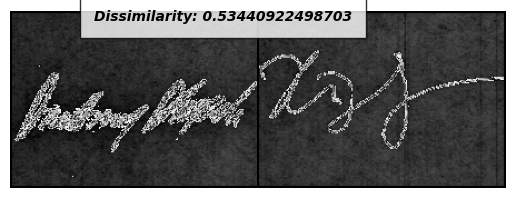

tensor([1.1517], device='cuda:0', grad_fn=<NormBackward1>)


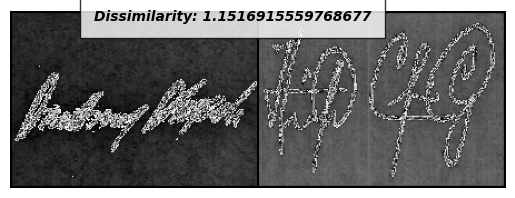

tensor([1.4751], device='cuda:0', grad_fn=<NormBackward1>)


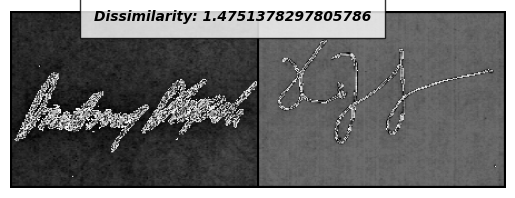

tensor([0.8078], device='cuda:0', grad_fn=<NormBackward1>)


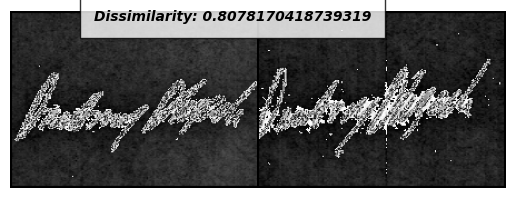

tensor([0.1826], device='cuda:0', grad_fn=<NormBackward1>)


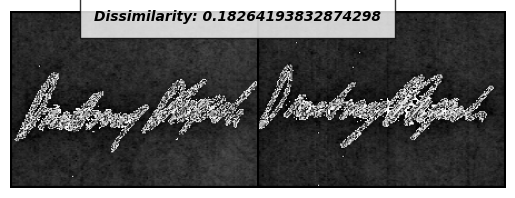

tensor([0.2911], device='cuda:0', grad_fn=<NormBackward1>)


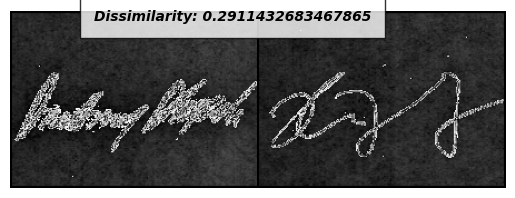

tensor([1.5746], device='cuda:0', grad_fn=<NormBackward1>)


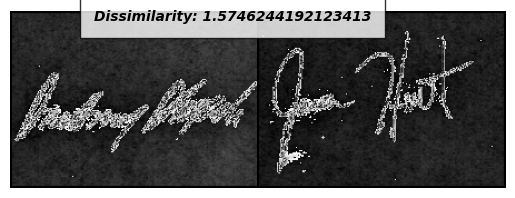

tensor([0.3065], device='cuda:0', grad_fn=<NormBackward1>)


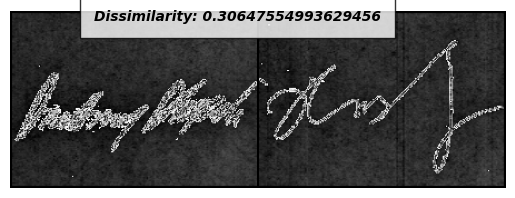

tensor([0.5050], device='cuda:0', grad_fn=<NormBackward1>)


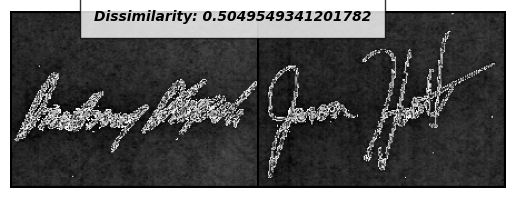

tensor([0.0293], device='cuda:0', grad_fn=<NormBackward1>)


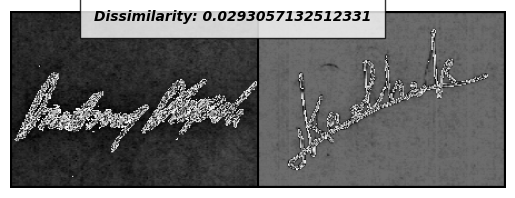

In [ ]:
dataiter = iter(test_loader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    with torch.no_grad():
      output1, output2 = model(x0.to(device), x1.to(device))
      euclidean_distance = F.pairwise_distance(output1, output2)

imshow(torchvision.utils.make_grid(concatenated), f"Dissimilarity: {euclidean_distance.item()}")


In [ ]:
model.eval()
running_loss = 0
number_samples = 0

distances = []

for batch_idx, (x1, x2, y) in enumerate(test_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)

    x1, x2 = model(x1, x2)
    loss = criterion(x1, x2, y)
    distances.extend(zip(torch.pairwise_distance(x1, x2, 2).cpu().tolist(), y.cpu().tolist()))

    number_samples += len(x1)
    running_loss += loss.item() * len(x1)

distances, y = zip(*distances)
distances, y = torch.tensor(distances), torch.tensor(y)
max_accuracy = accuracy(distances, y)
print(f'Max accuracy: {max_accuracy}')
